1. IMPORTS AND CONFIG 

In [158]:
import os
import pandas as pd
import cv2
import random
from ultralytics import YOLO
import matplotlib.pyplot as plt  # For visualizing images

%matplotlib inline 
#so visualization of resized images and bbox labels occurs inside notebook for train and val dataset


In [ ]:
#clearing the data set demo images & labels created the last time i ran this script so i can start from sratch everytime i run this script
import shutil

def clear_folder(folder_path):
    """Function to clear all files and subfolders in the given folder."""
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)  # Deletes the folder and all its contents
        os.makedirs(folder_path)  # Recreate an empty folder

# Clear the train/val image and label folders
print("Clearing dataset_demo/images and dataset_demo/labels folders...")
clear_folder(r'C:\Users\Annabelle\Desktop\runway-bounding-box-detection NEW\dataset_demo\images')
clear_folder(r'C:\Users\Annabelle\Desktop\runway-bounding-box-detection NEW\dataset_demo\labels')

print("Folders cleared successfully.")

2. PATHS AND PARAMETERS

only using the 'LARD_Train_Birk_LFST' folder of data, since the data set is so large and will take toO long to run. I will be taking a sample of images from  'LARD_Train_Birk_LFST' and divide the sample into training, validation and test data

In [159]:
# Specify the training folder to use
root_folder = r'C:\Users\Annabelle\Desktop\runway-bounding-box-detection NEW'
train_folder = 'LARD_train_BIRK_LFST' 

In [160]:
# Paths for images, metadata, and output
folder_path = os.path.join(root_folder, train_folder) #path to folder 'LARD_train_BIRK_LFST'
image_folder = os.path.join(folder_path, 'images') #path to the 'images' sub-folder in 'LARD_train_BIRK_LFST'
csv_path = os.path.join(folder_path, 'LARD_train_BIRK_LFST.csv')  # path to CSV file
output_folder = 'dataset_demo' #new folder for the sample of train & val images and labels taking for this

subset_size = 150  # Number of images to sample for train/val. doing small ammount to speed up demo/training time 

3. DATA PREPERATION

In [162]:
# Create output directories for train/val images and labels
os.makedirs(f'{output_folder}/images/train', exist_ok=True)
os.makedirs(f'{output_folder}/images/val', exist_ok=True)
os.makedirs(f'{output_folder}/labels/train', exist_ok=True)
os.makedirs(f'{output_folder}/labels/val', exist_ok=True)

In [163]:
# Load the CSV metadata with semicolon separator
df = pd.read_csv(csv_path, sep=';')

In [164]:
# Remove 'images/' prefix from filenames in the CSV if present
df['image'] = df['image'].str.replace('images/', '', regex=False).str.strip()

# DEBUGGING: Verify the adjustment by printing the first few filenames
print("Adjusted Filenames from the CSV:")
print(df['image'].head())  # Confirm that 'images/' prefix is removed

# Collect all available images from the dataset
images = [img for img in os.listdir(image_folder) if img.endswith(('.jpg', '.jpeg'))]
print(f"Total images found in folder: {len(images)}")

# Check if there are missing images based on the metadata
missing_files = [img for img in df['image'] if img not in images]
if missing_files:
    print(f"These images are listed in the CSV but not found in the folder: {missing_files}")
else:
    print("All CSV images match with folder images!")

Adjusted Filenames from the CSV:
0    BIRK_01_500_000.jpeg
1    BIRK_01_500_001.jpeg
2    BIRK_01_500_002.jpeg
3    BIRK_01_500_003.jpeg
4    BIRK_01_500_004.jpeg
Name: image, dtype: object
Total images found in folder: 1819
All CSV images match with folder images!


In [165]:
# Randomly sample images for train and validation sets
sampled_images = random.sample(images, min(subset_size, len(images)))
num_train = len(sampled_images) // 2
train_images = sampled_images[:num_train]
val_images = sampled_images[num_train:]


4. HELPER FUNCTIONS: BOUNDING BOX CONVERSION

In [166]:
# Helper function to scale bounding boxes with image resizing
def scale_bbox(corners, original_size, new_size):
    orig_w, orig_h = original_size
    new_w, new_h = new_size
    x_scale = new_w / orig_w
    y_scale = new_h / orig_h

    # Scale each corner's X and Y coordinates
    return [
        corners[i] * x_scale if i % 2 == 0 else corners[i] * y_scale
        for i in range(8)
    ]

# Helper function to convert scaled corners to YOLO format
def convert_to_yolo(size, corners):
    img_w, img_h = size
    x_min = min([corners[i] for i in range(0, 8, 2)])
    x_max = max([corners[i] for i in range(0, 8, 2)])
    y_min = min([corners[i] for i in range(1, 8, 2)])
    y_max = max([corners[i] for i in range(1, 8, 2)])

    x_center = (x_min + x_max) / (2 * img_w)
    y_center = (y_min + y_max) / (2 * img_h)
    width = (x_max - x_min) / img_w
    height = (y_max - y_min) / img_h
    return 0, x_center, y_center, width, height  # Class ID is 0 for runway


def visualize_resized_images_with_labels(image_path, corners):
    """Function to visualize resized images with their bounding boxes."""
    # Load and resize the image
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (640, 640))

    # Draw the bounding box on the image
    points = [(int(corners[i]), int(corners[i + 1])) for i in range(0, 8, 2)]
    for j in range(len(points)):
        cv2.line(img_resized, points[j], points[(j + 1) % 4], (0, 255, 0), 2)

    # Display the image with the bounding box
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()  # Ensure the plot renders

5. IMAGE PROCESSING AND LABEL GENERATION

In [167]:
# Process images and generate labels for train/val sets

# Images are resized to 640x640 because that is the required input size for YOLOv8.
# The runway metadata (bounding box corners) is scaled to match the resized image dimensions.
# the runway metadata from the LARD data set is the XY coordinates of each corner in  the runway bounding box & the last 8 columns of the CSV file
# and  it is also converted to YOLO format (x_center, y_center, width, height).

#read this for more info on the LARD dataset meta data structure: https://github.com/deel-ai/LARD/blob/main/data/infos.md

for subset, image_list in [('train', train_images), ('val', val_images)]:
    for img_file in image_list:
        img_path = os.path.join(image_folder, img_file)

        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_file}")
            continue

        orig_h, orig_w = img.shape[:2]
        img_resized = cv2.resize(img, (640, 640))
        output_img_path = f'{output_folder}/images/{subset}/{img_file}'
        cv2.imwrite(output_img_path, img_resized)

        base_filename, _ = os.path.splitext(img_file)
        label_file = os.path.join(output_folder, 'labels', subset, base_filename + '.txt')

        try:
            row = df[df['image'].str.strip().str.lower() == img_file.strip().lower()].iloc[0]
            corners = row.iloc[-8:].values.astype(float)
            scaled_corners = scale_bbox(corners, (orig_w, orig_h), (640, 640))
            label_data = convert_to_yolo((640, 640), scaled_corners)

            with open(label_file, 'w') as f:
                f.write(" ".join(map(str, label_data)) + '\n')

        except IndexError:
            print(f"No matching metadata found for image: {img_file}")

6. VISUALIZE RESIZED TRAIN AND VAL IMAGES & LABELS

Visualizing bounding boxes for train set:
Label data for LFST_23_500_085.jpeg: ['0', '0.3498774509803922', '0.47450906344410876', '0.013480392156862742', '0.020770392749244682']


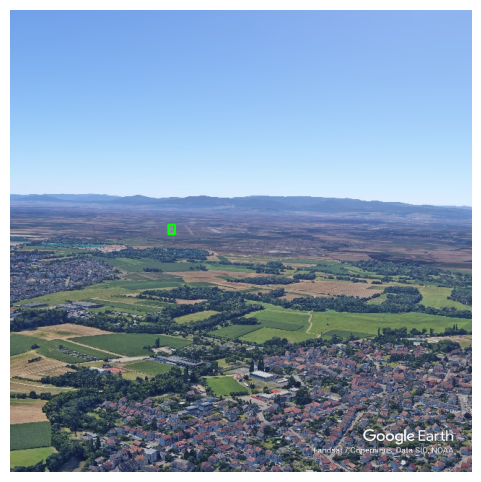

Label data for BIRK_01_500_084.jpeg: ['0', '0.4268790849673203', '0.4847054380664654', '0.020424836601307207', '0.0154833836858006']


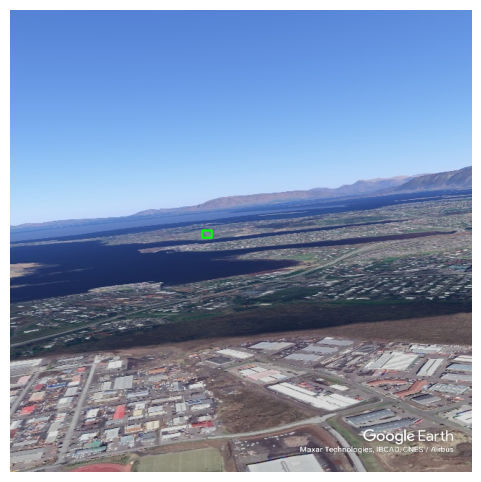

Label data for LFST_23_500_281.jpeg: ['0', '0.5845588235294118', '0.45827039274924475', '0.03267973856209148', '0.038897280966767325']


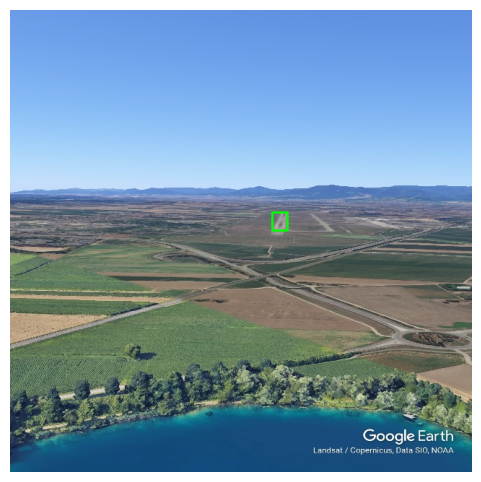

Label data for LFST_05_500_046.jpeg: ['0', '0.29983660130718953', '0.47620845921450156', '0.008986928104575177', '0.01963746223564957']


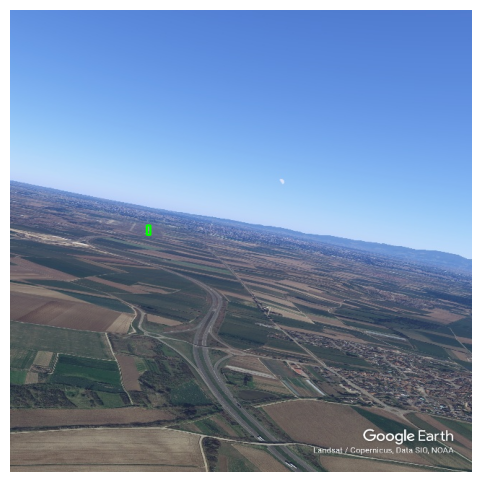

Label data for BIRK_13_500_055.jpeg: ['0', '0.7724673202614379', '0.4724320241691843', '0.022058823529411777', '0.01435045317220549']


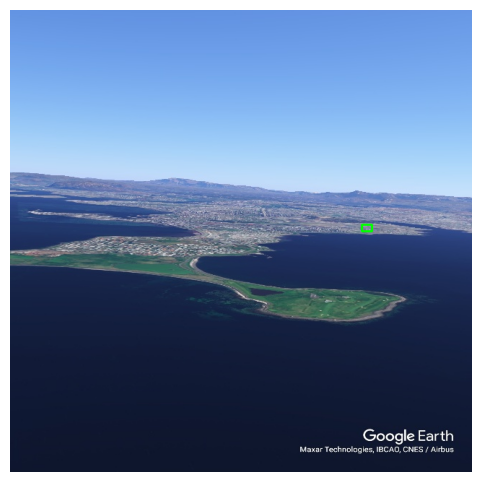

Visualizing bounding boxes for val set:
Label data for LFST_05_500_106.jpeg: ['0', '0.46875', '0.4777190332326285', '0.01674836601307188', '0.019637462235649484']


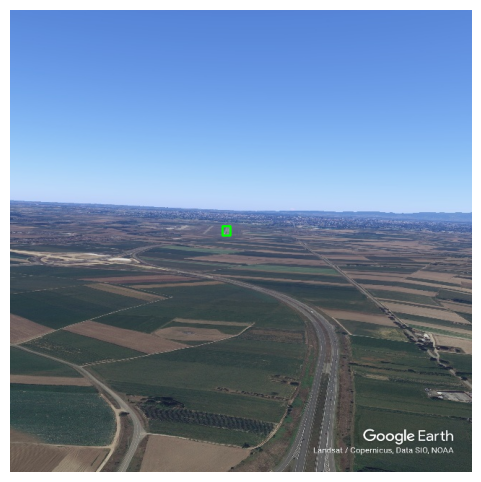

Label data for BIRK_01_500_431.jpeg: ['0', '0.6550245098039216', '0.4082326283987916', '0.1875', '0.10574018126888221']


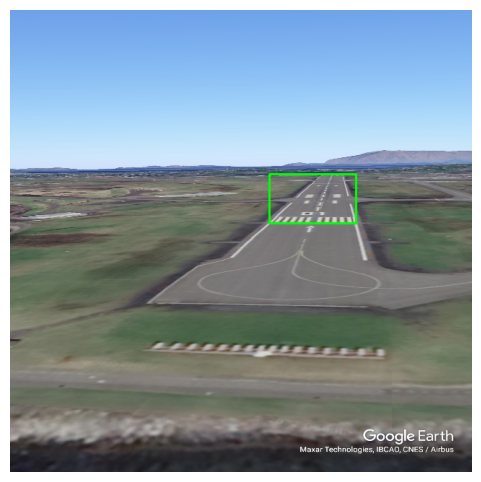

Label data for BIRK_01_500_171.jpeg: ['0', '0.516952614379085', '0.4669561933534744', '0.015114379084967312', '0.019259818731117838']


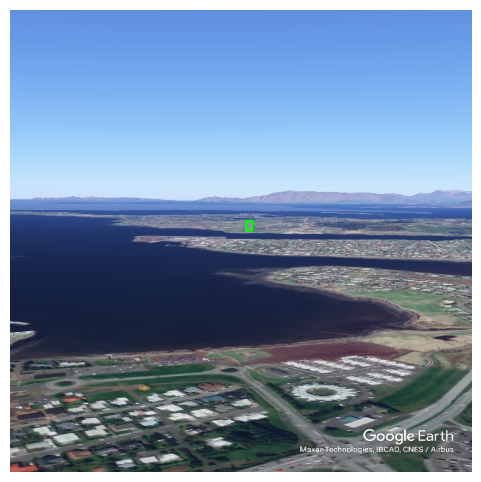

Label data for LFST_05_500_117.jpeg: ['0', '0.4581290849673203', '0.467333836858006', '0.026552287581699297', '0.020770392749244682']


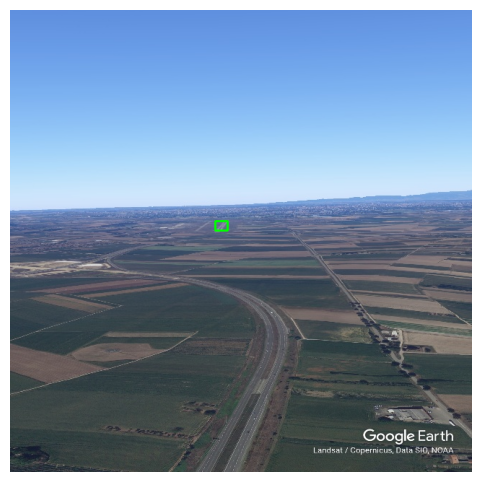

Label data for LFST_23_500_216.jpeg: ['0', '0.4013480392156863', '0.3838746223564955', '0.037173202614379085', '0.03134441087613293']


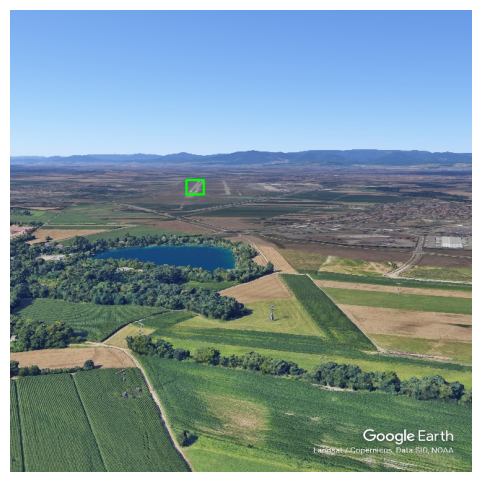

In [168]:
# Visualize bounding boxes in train and val datasets to ensure correct labeling
for subset in ['train', 'val']:
    print(f"Visualizing bounding boxes for {subset} set:")
    image_list = os.listdir(f'{output_folder}/images/{subset}')

    # Visualize up to 5 random images from the subset
    for img_file in random.sample(image_list, min(5, len(image_list))):
        img_path = os.path.join(output_folder, 'images', subset, img_file)

        # Load the corresponding label file
        label_file = os.path.join(
            output_folder, 'labels', subset, 
            img_file.replace('.jpeg', '.txt').replace('.jpg', '.txt')
        )

        with open(label_file, 'r') as f:
            label_data = f.readline().strip().split()

        # Print the label data for debugging
        print(f"Label data for {img_file}: {label_data}")

        # Ensure the label data is valid
        if len(label_data) == 5:
            # Extract class_id and bounding box values from the label
            class_id = int(label_data[0])
            x_center, y_center, width, height = map(float, label_data[1:])

            # Convert YOLO format back to corner points for visualization
            img_w, img_h = 640, 640  # Resized dimensions
            x_min = int((x_center - width / 2) * img_w)
            x_max = int((x_center + width / 2) * img_w)
            y_min = int((y_center - height / 2) * img_h)
            y_max = int((y_center + height / 2) * img_h)

            # Prepare corner coordinates for visualization
            corners = [x_min, y_min, x_max, y_min, x_max, y_max, x_min, y_max]

            # Visualize the image with bounding box using the helper function
            visualize_resized_images_with_labels(img_path, corners)
        else:
            print(f"Skipping {img_file} due to invalid label format.")


In [170]:
#SKIP FOR NOW WILL HARDCOODE YAM FILE
# Create YAML configuration file
#yaml_content = f"""path: {output_folder}
#train: images/train
#val: images/val
#nc: 1
#names: ['runway']
#"""

In [171]:
#SKIP FOR NOW WILL HARDCOODE YAM FILE
#with open(f'{output_folder}/runway.yaml', 'w') as f:
   # f.write(yaml_content)

#print("Data preparation complete!")

7. TRAIN AND TEST YOLOV8

Ultralytics 8.3.23  Python-3.11.9 torch-2.5.0+cpu CPU (AMD Ryzen 7 5800X 8-Core Processor)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset_demo\runway.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train24, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

train: Scanning C:\Users\Annabelle\Desktop\runway-bounding-box-detection NEW\dataset_demo\labels\train... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 2986.66it/s]

train: New cache created: C:\Users\Annabelle\Desktop\runway-bounding-box-detection NEW\dataset_demo\labels\train.cache



val: Scanning C:\Users\Annabelle\Desktop\runway-bounding-box-detection NEW\dataset_demo\labels\val... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 3106.34it/s]

val: New cache created: C:\Users\Annabelle\Desktop\runway-bounding-box-detection NEW\dataset_demo\labels\val.cache
Plotting labels to runs\detect\train24\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train24
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.453      7.478      1.617         16        640: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

                   all         75         75    0.00147       0.44    0.00148   0.000575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.768      5.951      1.264         20        640: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

                   all         75         75    0.00267        0.8      0.024     0.0116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.526       5.09      1.047         16        640: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.97s/it]

                   all         75         75    0.00289      0.867      0.111     0.0539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.409      4.039      1.006         17        640: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

                   all         75         75    0.00284      0.853     0.0661     0.0334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.271      4.147      1.026         14        640: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

                   all         75         75    0.00284      0.853     0.0638     0.0256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.235      3.844      0.942         17        640: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.09s/it]

                   all         75         75    0.00284      0.853     0.0475     0.0224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.408      3.316      1.085         18        640: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]

                   all         75         75    0.00289      0.867     0.0212     0.0161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.351       3.89      1.069         10        640: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.02s/it]

                   all         75         75    0.00289      0.867     0.0238      0.018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.347      3.093      1.036         15        640: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.03s/it]

                   all         75         75    0.00258      0.773     0.0109     0.0051



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G       1.39      3.322     0.9693         15        640: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

                   all         75         75    0.00249      0.747     0.0334     0.0173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.319      2.804      1.036         18        640: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

                   all         75         75    0.00267        0.8      0.003    0.00178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.186       2.69       1.01         16        640: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.97s/it]

                   all         75         75    0.00271      0.813    0.00394    0.00262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.279      2.729     0.9788         13        640: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.00s/it]

                   all         75         75     0.0066       0.04    0.00491    0.00331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.355      2.444      1.028         13        640: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]

                   all         75         75       0.66       0.12      0.158      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.231      2.449     0.9906         18        640: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

                   all         75         75      0.773     0.0933      0.155      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.283      2.352     0.9869         14        640: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]

                   all         75         75      0.369       0.12      0.196      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.199      1.866     0.9561         14        640: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.97s/it]

                   all         75         75      0.407      0.338      0.239      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.298      2.349     0.9797         16        640: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.94s/it]

                   all         75         75      0.312       0.16      0.196      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.167      2.337     0.9926         17        640: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.96s/it]

                   all         75         75       0.72      0.507      0.657      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.224      2.048      1.004         19        640: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.94s/it]

                   all         75         75      0.852      0.769      0.854      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.274      2.254      1.018         15        640: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]

                   all         75         75      0.744      0.777      0.811      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G        1.1      1.915       0.97         18        640: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]

                   all         75         75      0.821       0.76      0.838      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.094      1.925     0.9532         14        640: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]

                   all         75         75      0.912      0.829      0.887      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.146      2.212     0.9456         14        640: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.96s/it]

                   all         75         75      0.969      0.835      0.918       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.012      1.743     0.8884         22        640: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

                   all         75         75      0.958      0.906      0.903      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.107      1.724     0.9636         16        640: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

                   all         75         75      0.969       0.92      0.933      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G       0.96      1.553     0.9858         19        640: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]

                   all         75         75      0.984       0.92      0.937      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.9709      1.678     0.9212          9        640: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]

                   all         75         75      0.944        0.9      0.914      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.036      1.625     0.9883         14        640: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]

                   all         75         75      0.944      0.897      0.916      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.9542      1.649     0.9208         17        640: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

                   all         75         75          1      0.905       0.92      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      0.921      1.495     0.9193         18        640: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]

                   all         75         75          1      0.918      0.945      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G       1.01      1.485     0.9968         20        640: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]

                   all         75         75      0.984      0.933      0.983      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.9844       1.55     0.9407         20        640: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

                   all         75         75      0.984      0.933      0.983      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.022      1.727     0.9756          9        640: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

                   all         75         75          1      0.931      0.979      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.9961      1.441     0.9461         23        640: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

                   all         75         75      0.995      0.933      0.971      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.9908      1.411      0.981         20        640: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

                   all         75         75          1      0.931      0.963      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.8875      1.299     0.9282         21        640: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]

                   all         75         75          1      0.932      0.965      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.9322      1.447     0.9723         20        640: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

                   all         75         75          1      0.933      0.973      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.9336       1.44     0.8985         11        640: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]

                   all         75         75      0.987      0.933      0.981      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.8122      1.204      0.956         19        640: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]

                   all         75         75      0.973      0.965      0.983      0.771


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.8275      1.284     0.8922         11        640: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]

                   all         75         75      0.998       0.96      0.983      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.8222      1.372      0.861         11        640: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]

                   all         75         75      0.997       0.96      0.984      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.7705      1.313     0.8316         11        640: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]

                   all         75         75      0.997       0.96      0.984      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.7461      1.283     0.8621         11        640: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]

                   all         75         75      0.998      0.973      0.985      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.7907      1.291      0.893         11        640: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]

                   all         75         75          1      0.973      0.985      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.7456      1.305     0.8758         11        640: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

                   all         75         75          1       0.97      0.985      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      0.724      1.264     0.8669         11        640: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

                   all         75         75          1      0.966      0.984      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.7004      1.187     0.8437         11        640: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]

                   all         75         75      0.986       0.97      0.984      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.6732      1.169     0.8482         11        640: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

                   all         75         75      0.986      0.966      0.983      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.6455      1.221     0.8507         11        640: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.87s/it]

                   all         75         75      0.986       0.96      0.983      0.805



50 epochs completed in 0.283 hours.
Optimizer stripped from runs\detect\train24\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train24\weights\best.pt, 6.2MB

Validating runs\detect\train24\weights\best.pt...
Ultralytics 8.3.23  Python-3.11.9 torch-2.5.0+cpu CPU (AMD Ryzen 7 5800X 8-Core Processor)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


                   all         75         75      0.986       0.96      0.983      0.805
Speed: 1.8ms preprocess, 55.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\train24

image 1/1 C:\Users\Annabelle\Desktop\runway-bounding-box-detection NEW\test_image_resized.jpeg: 640x640 1 runway, 37.1ms
Speed: 1.0ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


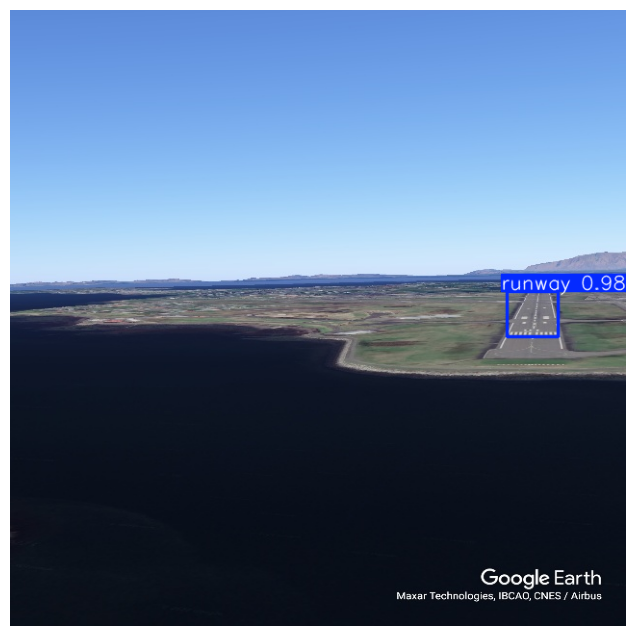

Training, evaluation, and testing complete!


In [172]:

# Train the YOLOv8 model using the generated dataset
model = YOLO('yolov8n.pt')  # Use the nano model for faster training
model.train(data=os.path.join(output_folder, 'runway.yaml'), epochs=50, imgsz=640)

# Path to the test image
test_image = r'C:\Users\Annabelle\Desktop\runway-bounding-box-detection NEW\test_image_resized.jpeg'

# Run the model on the test image and store the result
results = model.predict(source=test_image)


# VISUALIZE TEST IMAGE WITH BOUNDING BOXES
import matplotlib.pyplot as plt

# Ensure Matplotlib inline rendering
# %matplotlib inline

def visualize_test_image_with_results(results):
    """Visualize the test image with predicted bounding boxes."""
    for r in results:
        # Get the image with predictions drawn on it
        img = r.plot()  # `r.plot()` returns an image with drawn bounding boxes

        # Display the image using Matplotlib
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Hide axes for cleaner display
        plt.show()

# Call the visualization function to display the test image with predictions
visualize_test_image_with_results(results)

print("Training, evaluation, and testing complete!")
